# 9.1
## a)

In [43]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.signal import detrend


In [30]:
nao_raw_data = xr.open_dataset(r'..\data\processed\tas_pres_DJF_1948_2024.nc')


In [32]:
island = nao_raw_data.sel(lat = 64, lon = -22, method='nearest')
azores = nao_raw_data.sel(lat = 39, lon = -28, method='nearest')    


In [58]:
nao_index_raw = azores.pres - island.pres
nao_index_standardized = (nao_index_raw-nao_index_raw.mean(dim='year')) / nao_index_raw.std(dim='year')


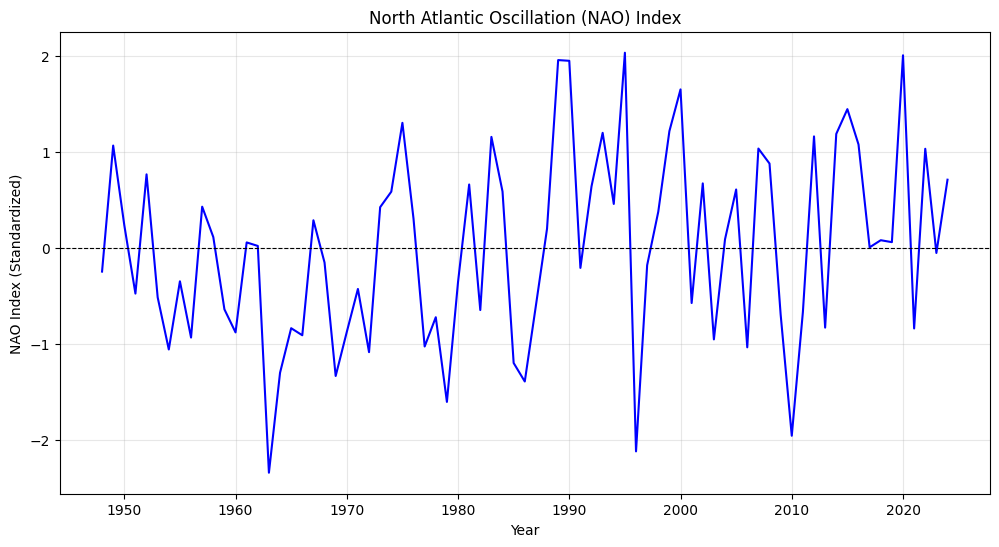

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(nao_raw_data.year, nao_index_standardized, color='blue', linewidth=1.5)
plt.title('North Atlantic Oscillation (NAO) Index')
plt.xlabel('Year')
plt.ylabel('NAO Index (Standardized)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.show()


## b)

c:\Users\Hanne\Anaconda3\envs\HIWI\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Hanne\Anaconda3\envs\HIWI\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


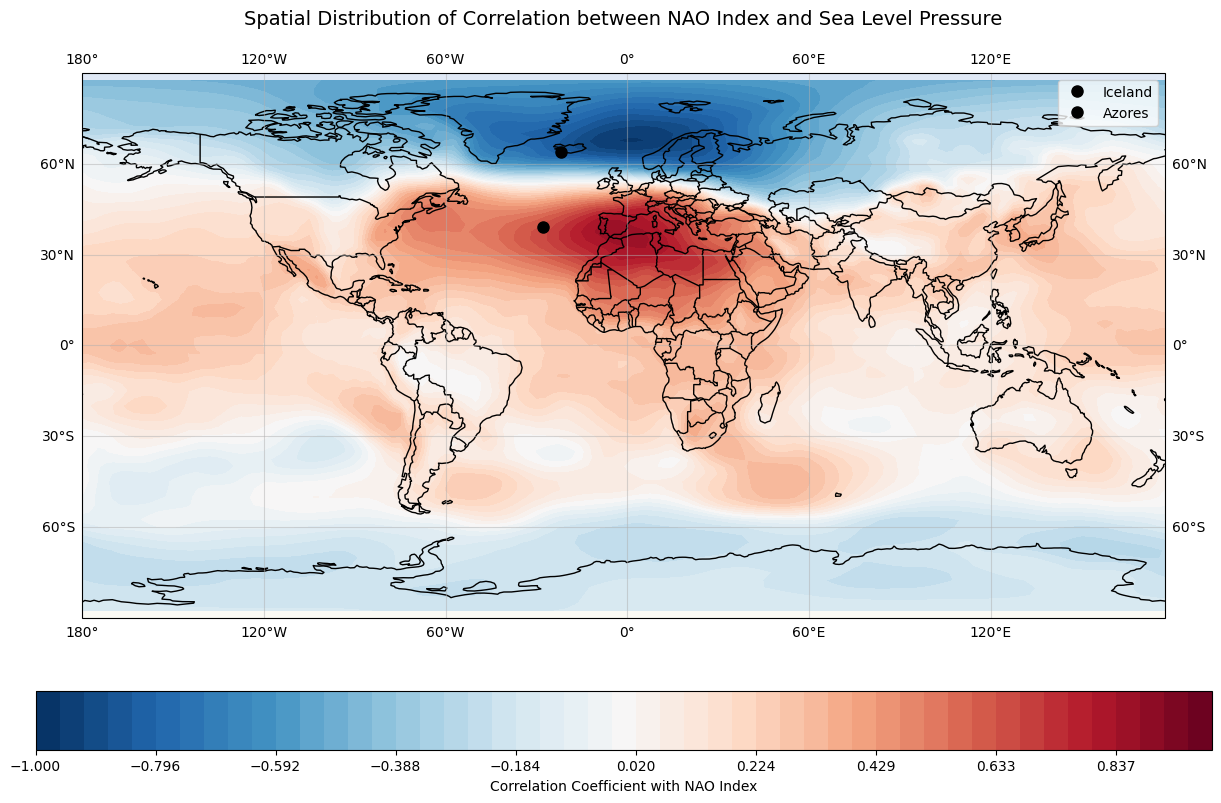

Maximum correlation: 0.868
Minimum correlation: -0.964
Mean absolute correlation: 0.245


In [ ]:
# Calculate correlation between NAO index and pressure at each grid point
correlation = xr.corr(nao_index_standardized, nao_raw_data.pres, dim='year')

# Convert longitude from 0-360 to -180-180 for proper plotting
correlation_fixed = correlation.assign_coords(lon=(((correlation.lon + 180) % 360) - 180))
correlation_fixed = correlation_fixed.sortby('lon')

# Create spatial plot of correlation coefficients
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot correlation coefficients
im = ax.contourf(correlation_fixed.lon, correlation_fixed.lat, correlation_fixed, 
                 levels=np.linspace(-1, 1, 50), 
                 cmap='RdBu_r', transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN, alpha=0.3)
ax.add_feature(cfeature.LAND, alpha=0.3)

# Add gridlines
ax.gridlines(draw_labels=True, alpha=0.5)

# Mark Iceland and Azores locations
ax.plot(-22, 64, 'ko', markersize=8, transform=ccrs.PlateCarree(), label='Iceland')
ax.plot(-28, 39, 'ko', markersize=8, transform=ccrs.PlateCarree(), label='Azores')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)
cbar.set_label('Correlation Coefficient with NAO Index')

# Set title and labels
ax.set_title('Spatial Distribution of Correlation between NAO Index and Sea Level Pressure', 
             fontsize=14, pad=20)
ax.legend()

plt.tight_layout()
plt.show()


## c)

The spatial correlation pattern reveals a characteristic large-scale dipole structure typical of the North Atlantic Oscillation. The analysis shows negative correlations in the northern regions (where sea level pressure decreases as the NAO index increases) and positive correlations in the southern regions (where pressure increases with rising NAO indices). 

When compared to established literature, our correlation analysis demonstrates good agreement with known NAO patterns. However, one notable difference is that the centers of the dipole structures appear to be shifted slightly eastward relative to the canonical NAO pattern. 

Overall, the results successfully reproduce the fundamental characteristics of the NAO pressure dipole.

# 9.2
## a)

**Linear Regression** is a statistical method that models the relationship between a dependent variable (y) and an independent variable (x) using a straight line: y = ax + b. The method finds the best-fit line by minimizing the sum of squared residuals between observed and predicted values. In climate analysis, it quantifies how much one variable changes in response to unit changes in another variable.

## b)

In [62]:
nao_detrended = detrend(nao_index_standardized, type='linear')


In [63]:
temp = nao_raw_data.tas


In [ ]:
# Remove mean and linear trend from temperature data
# First remove the temporal mean
temp_demeaned = temp - temp.mean(dim='year')

# Apply detrending to remove linear trend for each grid point
temp_detrended = xr.apply_ufunc(
    detrend,
    temp_demeaned,
    input_core_dims=[['year']],
    output_core_dims=[['year']],
    vectorize=True,
    dask='allowed'
)


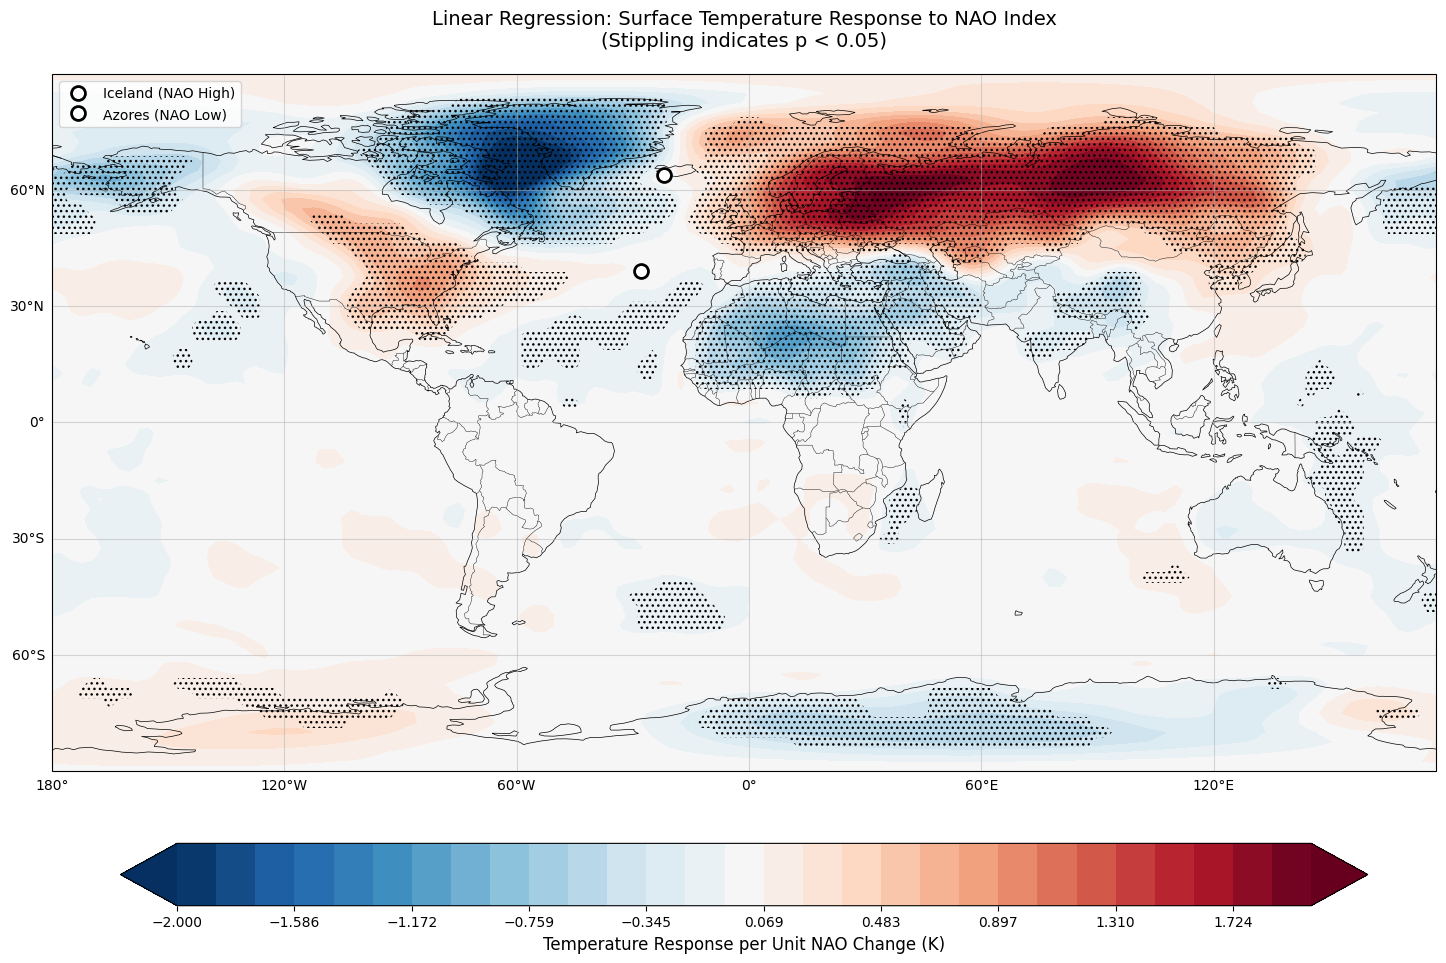

In [79]:
from scipy import stats

# Calculate linear regression between NAO index and temperature at each grid point
def linear_regression_2d(nao, temp):
    """Calculate linear regression for 2D temperature field against 1D NAO index"""
    slopes = np.full((temp.shape[0], temp.shape[1]), np.nan)
    p_values = np.full((temp.shape[0], temp.shape[1]), np.nan)
    
    for i in range(temp.shape[0]):  # latitude
        for j in range(temp.shape[1]):  # longitude
            temp_series = temp[i, j, :]
            # Only calculate if we have valid data
            if not np.isnan(temp_series).all():
                slope, intercept, r_value, p_value, std_err = stats.linregress(nao, temp_series)
                slopes[i, j] = slope
                p_values[i, j] = p_value
    
    return slopes, p_values

# Calculate regression coefficients
slopes, p_values = linear_regression_2d(nao_detrended, temp_detrended.values)

# Create DataArrays for the results
slopes_da = xr.DataArray(
    slopes,
    coords={'lat': temp_detrended.lat, 'lon': temp_detrended.lon},
    dims=['lat', 'lon'],
    name='temperature_slope',
    attrs={'long_name': 'Temperature response per unit NAO change', 'units': 'K/NAO_unit'}
)

p_values_da = xr.DataArray(
    p_values,
    coords={'lat': temp_detrended.lat, 'lon': temp_detrended.lon},
    dims=['lat', 'lon'],
    name='p_values',
    attrs={'long_name': 'Statistical significance (p-value)'}
)

# Convert longitude for proper plotting
slopes_fixed = slopes_da.assign_coords(lon=(((slopes_da.lon + 180) % 360) - 180))
slopes_fixed = slopes_fixed.sortby('lon')
p_values_fixed = p_values_da.assign_coords(lon=(((p_values_da.lon + 180) % 360) - 180))
p_values_fixed = p_values_fixed.sortby('lon')

# Create the regression map
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot regression slopes with constrained range
levels = np.linspace(-2, 2, 30)
im = ax.contourf(slopes_fixed.lon, slopes_fixed.lat, slopes_fixed, 
                 levels=levels, cmap='RdBu_r', transform=ccrs.PlateCarree(), extend='both')

# Add statistical significance stippling
significance = p_values_fixed < 0.05
ax.contourf(p_values_fixed.lon, p_values_fixed.lat, significance, 
            levels=[0.5, 1.5], colors='none', hatches=['...'], alpha=0, transform=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)
ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')

# Add gridlines
gl = ax.gridlines(draw_labels=True, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Mark NAO centers
ax.plot(-22, 64, 'ko', markersize=10, transform=ccrs.PlateCarree(), 
        markerfacecolor='white', markeredgewidth=2, label='Iceland (NAO High)')
ax.plot(-28, 39, 'ko', markersize=10, transform=ccrs.PlateCarree(), 
        markerfacecolor='white', markeredgewidth=2, label='Azores (NAO Low)')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.08, shrink=0.8)
cbar.set_label('Temperature Response per Unit NAO Change (K)', fontsize=12)

# Set title
ax.set_title('Linear Regression: Surface Temperature Response to NAO Index\n(Stippling indicates p < 0.05)', 
             fontsize=14, pad=20)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()


## c)

The regression analysis reveals distinct regional patterns in surface temperature response to NAO variability, demonstrating the far-reaching influence of North Atlantic atmospheric dynamics on hemispheric climate through established teleconnection mechanisms.

**European-Asian Sector:**
Northern and Western Europe show the strongest positive temperature response to NAO variability, with regression coefficients reaching 1-2K per unit NAO change. During positive NAO phases, the intensified pressure gradient between the Icelandic Low and Azores High strengthens the westerly flow, enhancing the advection of warm, moist maritime air masses from the Atlantic Ocean. This process is further amplified by:
- Enhanced storm track activity that increases meridional heat transport
- Reduced blocking patterns that would otherwise allow cold Arctic air to penetrate southward
- Increased cloud cover and latent heat release over continental regions

The positive temperature anomalies extending into Central Asia reflect the downstream propagation of Rossby waves, illustrating the NAO's role in hemispheric-scale atmospheric teleconnections.

**North American Sector:**
A pronounced meridional dipole characterizes the temperature response over North America. Northern regions (Canada/Alaska) exhibit negative correlations (-0.5 to -1K per NAO unit), while the southern United States shows positive responses. This pattern results from NAO-induced modifications to the mean atmospheric circulation:
- Positive NAO phases strengthen the westerly jet, reducing meridional flow and limiting cold air outbreaks from the Arctic
- Arctic regions experience relative cooling due to reduced heat transport from lower latitudes

**African and Mediterranean Region:**
North Africa and the Mediterranean basin display weak but consistent negative temperature responses during positive NAO phases.
